In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
import os
import glob
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import zipfile
from google.colab import drive

Initialize tokenizer

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Load and prepare dataset from zip file & excel sheet

In [ ]:
def load_emotion_dataset(zip_path, extract_path='/content/drive/MyDrive/EmotionClassText/'):
    # Check if extraction folder already exists
    if not os.path.exists(extract_path):
        print(f"Extracting zip file to {extract_path}...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
    else:
        print(f"Extraction folder {extract_path} already exists, skipping extraction.")

    emotions = ['surprise', 'sad', 'neutral', 'happy', 'fear', 'disgust', 'anger']
    data = []

    for emotion in emotions:
        folder_path = os.path.join(extract_path, emotion)
        if not os.path.exists(folder_path):
            print(f"Warning: Folder for {emotion} not found in extracted zip")
            continue
        files = glob.glob(os.path.join(folder_path, '*.txt'))
        for file in files:
            with open(file, 'r', encoding='utf-8') as f:
                text = f.read().strip()
                data.append({'Phrase': text, 'Emotion': emotion})

    df = pd.DataFrame(data)
    # Map emotions to numerical labels
    emotion_to_idx = {emotion: idx for idx, emotion in enumerate(emotions)}
    df['Label'] = df['Emotion'].map(emotion_to_idx)
    return df, emotions

In [ ]:
def load_emotion_dataset(excel_path):
    # Read Excel file
    if not os.path.exists(excel_path):
        raise FileNotFoundError(f"Excel file not found at {excel_path}")

    df = pd.read_excel(excel_path)

    # Verify required columns
    if 'Phrase' not in df.columns or 'Emotion' not in df.columns:
        raise ValueError("Excel file must contain 'Phrase' and 'Emotion' columns")

    # Define emotions in the specified order
    expected_emotions = ['surprise', 'sad', 'neutral', 'happy', 'fear', 'disgust', 'anger']

    # Get unique emotions from the dataset
    unique_emotions = df['Emotion'].unique()
    # Validate emotions
    if not all(emotion in expected_emotions for emotion in unique_emotions):
        print(f"Warning: Found unexpected emotions in dataset: {set(unique_emotions) - set(expected_emotions)}")

    # Use expected emotions as classes to maintain consistent order
    classes = expected_emotions

    # Map emotions to numerical labels
    emotion_to_idx = {emotion: idx for idx, emotion in enumerate(classes)}
    df['Label'] = df['Emotion'].map(emotion_to_idx)

    # Drop any rows with missing labels (if emotion not in expected_emotions)
    df = df.dropna(subset=['Label'])

    return df, classes

Path to zip file & excel sheet in Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_path = '/content/drive/MyDrive/EmotionClassText.zip'
df, classes = load_emotion_dataset(zip_path)

Extraction folder /content/drive/MyDrive/EmotionClassText/ already exists, skipping extraction.


In [ ]:
excel_path = '/content/drive/MyDrive/EmotionText.xlsx'
df, classes = load_emotion_dataset(excel_path)

In [ ]:
df.info()
print(df.head())
df['Emotion'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13048 entries, 0 to 13047
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Phrase   13046 non-null  object
 1   Emotion  13048 non-null  object
 2   Label    13048 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 305.9+ KB
                                              Phrase   Emotion  Label
0                                 Okay, who are you?  surprise      0
1                                   Oh my God! Joey!  surprise      0
2                     Why?! Why can’t she marry me?!  surprise      0
3                                         Oh my God.  surprise      0
4  Now I can’t believe it! What? Rachel’s pregnan...  surprise      0


,count
Emotion,
neutral,2899
happy,1813
anger,1786
disgust,1722
sad,1695
fear,1648
surprise,1485


In [ ]:
print(df)

                                                  Phrase   Emotion  Label
0                                     Okay, who are you?  surprise      0
1                                       Oh my God! Joey!  surprise      0
2                         Why?! Why can’t she marry me?!  surprise      0
3                                             Oh my God.  surprise      0
4      Now I can’t believe it! What? Rachel’s pregnan...  surprise      0
...                                                  ...       ...    ...
13043  i am feeling much less like a grumpy bear now ...     anger      6
13044          i very selfishly feel wronged in some way     anger      6
13045  i feel like i can think circles around half of...     anger      6
13046           i started to feel resentful and hopeless     anger      6
13047  i feel insulted that youd prefer a meeting wit...     anger      6

[13048 rows x 3 columns]


In [ ]:
df.to_excel('/content/drive/MyDrive/EmotionText.xlsx', index=False) # index=False prevents writing the DataFrame index to Excel

Tokenize data

In [ ]:
def prepare_data(text, tokenizer):
    token = tokenizer.encode_plus(
        text,
        max_length=256,
        truncation=True,
        padding='max_length',
        add_special_tokens=True,
        return_tensors='tf'
    )
    return {
        'input_ids': tf.cast(token.input_ids, tf.int32),
        'attention_mask': tf.cast(token.attention_mask, tf.int32)
    }

In [ ]:
def generate_training_data(df, tokenizer):
    input_ids = np.zeros((len(df), 256), dtype=np.int32)
    attn_masks = np.zeros((len(df), 256), dtype=np.int32)

    for i, text in tqdm(enumerate(df['Phrase']), total=len(df)):
        tokenized = prepare_data(text, tokenizer)
        input_ids[i, :] = tokenized['input_ids']
        attn_masks[i, :] = tokenized['attention_mask']

    labels = np.zeros((len(df), 7), dtype=np.int32)
    labels[np.arange(len(df)), df['Label'].values] = 1
    return input_ids, attn_masks, labels

Prepare data

In [ ]:
input_ids, attn_masks, labels = generate_training_data(df, tokenizer)

Create TensorFlow dataset

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((input_ids, attn_masks, labels))
dataset = dataset.map(lambda x, y, z: ({'input_ids': x, 'attention_mask': y}, z))
dataset = dataset.shuffle(10000).batch(16, drop_remainder=True)

Split dataset

In [ ]:
p = 0.8
train_size = int((len(df)//16) * p)
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

Build model

In [ ]:
def build_model():
    input_ids = tf.keras.layers.Input(shape=(256,), name='input_ids', dtype='int32')
    attn_masks = tf.keras.layers.Input(shape=(256,), name='attention_mask', dtype='int32')

    bert = TFBertModel.from_pretrained('bert-base-cased')
    bert_embds = bert(input_ids, attention_mask=attn_masks)[1]
    intermediate = tf.keras.layers.Dense(512, activation='relu', name='intermediate')(bert_embds)
    output = tf.keras.layers.Dense(7, activation='softmax', name='output')(intermediate)

    model = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=[tf.keras.metrics.CategoricalAccuracy('accuracy')]
    )
    return model

Train model

In [ ]:
model = build_model()

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5
)

Epoch 1/5
652/652 [==============================] - 586s 843ms/step - loss: 1.1894 - accuracy: 0.5792 - val_loss: 0.8675 - val_accuracy: 0.7040
Epoch 2/5
652/652 [==============================] - 549s 842ms/step - loss: 0.8504 - accuracy: 0.7102 - val_loss: 0.6572 - val_accuracy: 0.7899
Epoch 3/5
652/652 [==============================] - 549s 842ms/step - loss: 0.7052 - accuracy: 0.7670 - val_loss: 0.5334 - val_accuracy: 0.8259
Epoch 4/5
652/652 [==============================] - 550s 843ms/step - loss: 0.5891 - accuracy: 0.8095 - val_loss: 0.3778 - val_accuracy: 0.8892
Epoch 5/5
652/652 [==============================] - 549s 842ms/step - loss: 0.4545 - accuracy: 0.8499 - val_loss: 0.2699 - val_accuracy: 0.9233


Epoch 1/2
652/652 [==============================] - 621s 892ms/step - loss: 1.2806 - accuracy: 0.5376 - val_loss: 1.0177 - val_accuracy: 0.6476

---
Epoch 2/2
652/652 [==============================] - 588s 902ms/step - loss: 0.9174 - accuracy: 0.6889 - val_loss: 0.7182 - val_accuracy: 0.7588

---

Save model

In [ ]:
model.save('MCTC_Emotion.keras')

/usr/local/lib/python3.11/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


In [ ]:
model.save("/content/drive/MyDrive/MCTC_Emotion5epoch.h5")

/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Prediction function

In [ ]:
def predict_emotion(text, model, tokenizer):
    inputs = prepare_data(text, tokenizer)
    probs = model.predict([inputs['input_ids'], inputs['attention_mask']])[0]
    return classes[np.argmax(probs)], probs

Test predictions

In [ ]:
test_phrases = [
    #"I love this!",
    #"This is terrible",
    #"It's okay, I guess",
    #"I really Hate this",
    #"Wow I didn't see that coming",
    #"This make me wanna vomit",
    #"My body got colder hearing about that",
    #"happy",
    #"sad",
    #"angry",
    #"disgust",
    #"surprise",
    #"fear",
    #"neutral",
    "Oh my God!!",#surprise
    "I didn’t make it!",#sad
    "You know how much I love listening to your music, you know,    but...",#neutral
    "Alright, you did it! Do we have any fruit?",#happy
    "i feel insecure and useless",#fear
    "I reached into the leper colony and felt a fungal decomposing rat cling to my hair, amid the hum of bloated mosquitoes.",#disgust
    "Did it ever occur to you that I might just be that stupid?"#angry
]

In [ ]:
print(classes)
for phrase in test_phrases:
    pred_class, probs = predict_emotion(phrase, model, tokenizer)
    print(f"\n'{phrase}':")
    print(f"Predicted: {pred_class}")
    print(f"Probabilities: {[f'{p:.4f}' for p in probs]}")

['surprise', 'sad', 'neutral', 'happy', 'fear', 'disgust', 'anger']
1/1 [==============================] - 4s 4s/step

'Oh my God!!':
Predicted: surprise
Probabilities: ['0.9815', '0.0028', '0.0017', '0.0022', '0.0007', '0.0028', '0.0083']
1/1 [==============================] - 0s 66ms/step

'I didn’t make it!':
Predicted: sad
Probabilities: ['0.1760', '0.3271', '0.0557', '0.1690', '0.0637', '0.0176', '0.1909']
1/1 [==============================] - 0s 67ms/step

'You know how much I love listening to your music, you know,    but...':
Predicted: happy
Probabilities: ['0.0014', '0.0215', '0.4637', '0.4821', '0.0091', '0.0031', '0.0192']
1/1 [==============================] - 0s 68ms/step

'Alright, you did it! Do we have any fruit?':
Predicted: happy
Probabilities: ['0.0170', '0.0013', '0.0048', '0.9387', '0.0017', '0.0010', '0.0355']
1/1 [==============================] - 0s 68ms/step

'i feel insecure and useless':
Predicted: fear
Probabilities: ['0.0006', '0.0008', '0.0001', '0.0000'

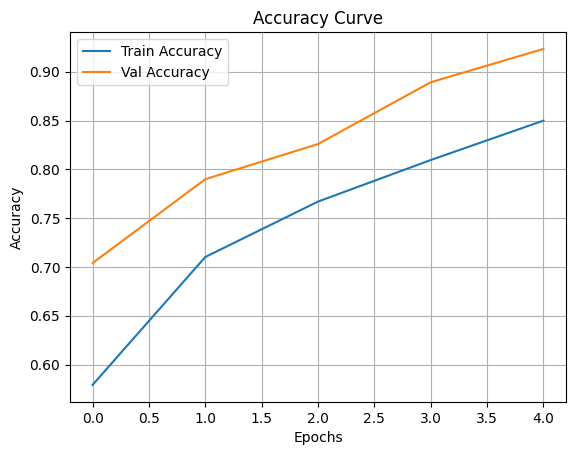

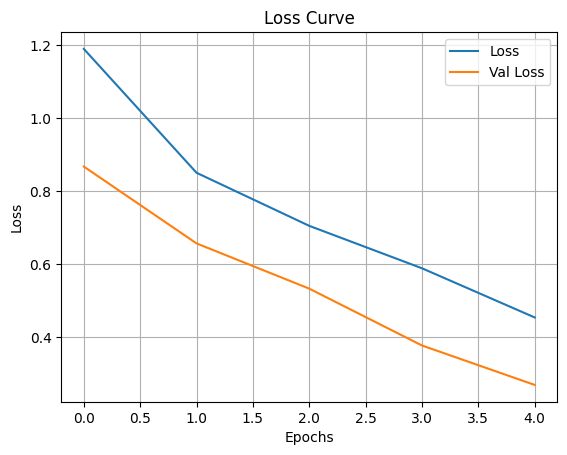

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)
plt.show()